# Error Measurement

In [ ]:
# so far I've gotten the algorithm into 1 cell and set up testing and training sets
# I need to get recs_nona and test to be the same size so I can compare with RMSE

In this notebook we will calcluate the RMSE of the collaborative filtering algorithm. We will create a test set of ratings containing one rating for each user. The remaining data will be treated as a training set, which will run through the algorithm to get a final recommendation. The RMSE will be calculated between the two sets of numbers. This will be compared to some baseline metrics as a point of reference.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from statistics import pstdev
import random

In [2]:
# set preferences for displaying dataframes
pd.set_option('display.max_columns', None)

In [3]:
# read in the books and ratings dataframes
ratings = pd.read_csv("Data/ratings_cleaned.csv")
books = pd.read_csv("Data/books_cleaned.csv")

In [4]:
ratings.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [5]:
books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url,goodreads_book_id,genre1,genre2,genre3
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,2767052,young-adult,fiction,fantasy
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,3,fantasy,young-adult,fiction
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...,41865,young-adult,fantasy,fiction
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...,2657,classics,historical-fiction,young-adult
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...,4671,classics,fiction,historical-fiction


## Train & Test Sets

In [6]:
# create test set with 1 rating from each user
test = ratings.groupby('user_id').apply(lambda x: x.sample(1)).reset_index(level=0, drop=True)

# create lists from test df
test_rating_list = test['rating'].tolist()
index_list = test.index.tolist()

# make new ratings column without test set
ratings = ratings.loc[~ratings.index.isin(index_list)]

## Algorithm

In [8]:
# make dataframe with only essential columns
books_cf = books[['id', 'title', 'authors', 'original_publication_year', 'genre1', 'genre2', 'genre3']].copy()

# convert original_publication_year to int, rename column to something shorter
books_cf['original_publication_year'] = books_cf['original_publication_year'].astype('Int64')
books_cf = books_cf.rename(columns={'original_publication_year': 'year'})

# rename book_id column to id in ratings df
ratings = ratings.rename(columns={'book_id': 'id'})

# sample user input
user_input = [
    
    {'title': '1984', 'authors': 'George Orwell, Erich Fromm, Celâl Üster', 'rating': 5},
    {'title': 'The Catcher in the Rye', 'authors': 'J.D. Salinger', 'rating': 5},
    {'title': 'The Great Gatsby', 'authors': 'F. Scott Fitzgerald', 'rating': 4},
    {'title': 'To Kill a Mockingbird', 'authors': 'Harper Lee', 'rating': 5},
    {'title': 'Of Mice and Men', 'authors': 'John Steinbeck', 'rating': 5}

]

# convert sample user input to dict
input_books = pd.DataFrame(user_input)

# filter the books by title, merge df's and drop year column
input_id = books_cf[books_cf['title'].isin(input_books['title'].tolist())]
input_books = pd.merge(input_id, input_books)
input_books = input_books.drop('year', axis=1)

# remove input books from books_cf 
input_book_list = input_books['id'].tolist()
books_cf = books_cf[~books_cf['id'].isin(input_book_list)]

# create a list of genres
genre_list = []
id_list = input_books['id'].tolist()

# for loop that appends unique genre tags to genre_list
for item in id_list:
    temp = books.loc[books['id'] == item]
    for i in range(24,27):
        a = temp.iloc[0, i]
        if a not in genre_list:
            genre_list.append(a)
            
# make average rating for each genre among user inputs
avg_genre_rating = []
for item in genre_list:
    temp_gdf = input_books.loc[(input_books['genre1'] == item) | \
                               (input_books['genre2'] == item) | \
                               (input_books['genre3'] == item)]
    c = temp_gdf['rating'].mean()
    avg_genre_rating.append(c)
    
# create dictionary among the two lists
genre_rating_dict = {genre_list[i]: avg_genre_rating[i] for i in range(len(genre_list))}

# filter users that have read books that the input has also read
user_subset = ratings[ratings['id'].isin(input_books['id'].tolist())]

# groupby user_id to create user subset group
user_subset_group = user_subset.groupby(['user_id'])

# sort so that users with book most in common with the input will have priority
user_subset_group = sorted(user_subset_group, key=lambda x: len(x[1]), reverse=True)

# limit number of users we look through to top 100
user_subset_group = user_subset_group[0:100]

# create dict of pearson correlation values
sim_dict = {}
std = pstdev(input_books['rating'].tolist())

# for loop that calculates Pearson correlation and stores values in above dict
for name, group in user_subset_group:
    
    group = group.sort_values(by='id')
    input_books = input_books.sort_values(by='id')
    num_ratings = len(group)
    
    # get the review scores for the books in common
    temp_df = input_books[input_books['id'].isin(group['id'].tolist())]

    # store both ratings in list for calculations        
    rating_list = temp_df['rating'].tolist()
    group_list = group['rating'].tolist()
    
    if std == 0:
    
        # calculate cosine similarity
        cos_sim = np.dot(rating_list, group_list)/(np.linalg.norm(rating_list)*np.linalg.norm(group_list))
        sim_dict[name] = cos_sim
        
    else:

        # calculate the pearson correlation between users 
        Sxx = sum([i**2 for i in rating_list]) - (sum(rating_list)**2 / float(num_ratings))
        Syy = sum([i**2 for i in group_list]) - (sum(group_list)**2 / float(num_ratings))
        Sxy = sum([i*j for i, j in zip(rating_list, group_list)]) \
              - (sum(rating_list) * sum(group_list) / float(num_ratings))

        # calculate Pearson corr if Sxx and Syy not 0, else set = 0
        if Sxx != 0 and Syy != 0:
            sim_dict[name] = Sxy/sqrt(Sxx*Syy)
        else:
            sim_dict[name] = 0
            
# convert dictionary to dataframe
sim_df = pd.DataFrame.from_dict(sim_dict, orient='index')
sim_df.columns = ['similarity_index']
sim_df['user_id'] = sim_df.index
sim_df.index = range(len(sim_df))

# get top 50 similar users
top_users = sim_df.sort_values(by='similarity_index', ascending=False)[0:50]
#top_users = top_users.loc[top_users['similarity_index'] >= 0]

# merge top_users df with ratings 
top_users_rating = top_users.merge(ratings, left_on='user_id', right_on='user_id', how='inner')

# multiply the user similarity by the user ratings
top_users_rating['weighted_rating'] = top_users_rating['similarity_index'] * top_users_rating['rating']

# apply a sum to the top_users after grouping it up by user_id
temp_top_users_rating = top_users_rating.groupby('id').sum()[['similarity_index','weighted_rating']]
temp_top_users_rating.columns = ['sum_similarity_index','sum_weighted_rating']

# create an empty dataframe
recommendation_df = pd.DataFrame()

# find the weighted average
recommendation_df['weighted average recommendation score'] = temp_top_users_rating['sum_weighted_rating'] \
                                                           / temp_top_users_rating['sum_similarity_index']
recommendation_df['id'] = temp_top_users_rating.index

# sort values in order of highest weights descending
recommendation_df = recommendation_df.sort_values(by='weighted average recommendation score', ascending=False)

recommendation_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2608 entries, 550 to 9991
Data columns (total 2 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   weighted average recommendation score  2094 non-null   float64
 1   id                                     2608 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 61.1 KB


In [29]:
recs_nona = recommendation_df[recommendation_df['weighted average recommendation score'].notnull()]
rec_list = recs_nona['id'].tolist()
recs_nona

,weighted average recommendation score,id
id,,
550,5.0,550
6751,5.0,6751
459,5.0,459
2078,5.0,2078
1496,5.0,1496
...,...,...
2815,1.0,2815
1547,1.0,1547
6752,1.0,6752


In [30]:
test.loc[test['book_id'].isin(rec_list)]

,book_id,user_id,rating
671282,6777,9,3
889526,9059,12,4
92297,925,35,4
751532,7607,46,5
847365,8613,101,3
...,...,...,...
943022,9637,53313,5
639380,6448,53389,4
696392,7037,53396,5
733297,7416,53411,4


In [9]:
recommendation_df.describe()

,weighted average recommendation score,id
count,2094.000000,2608.000000
mean,3.762181,2719.202454
std,0.847830,2445.026167
min,1.000000,1.000000
25%,3.000000,766.750000
50%,4.000000,1965.000000
75%,4.240403,4031.750000
max,5.000000,9991.000000


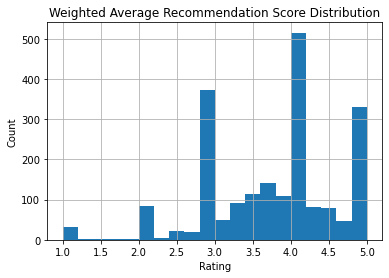

In [13]:
# plot the distribution of weighted average recommendation scores
_ = recommendation_df['weighted average recommendation score'].hist(bins=20)
_ = plt.title('Weighted Average Recommendation Score Distribution')
_ = plt.xlabel('Rating')
_ = plt.ylabel('Count')

The weighted ratings tend to hold the shape of the initial ratings distributions. 

In [10]:
# check the number of books that have perfect 5's as a recommendation score
fives = recommendation_df.loc[recommendation_df['weighted average recommendation score'] == 5]

if len(fives) > 10:
    
    count = 0
    scores = []
    
    # calculate genre score for each book
    for index, row in books_cf.iterrows():
        if row['genre1'] in genre_list:
            count += 5 * (genre_rating_dict[row['genre1']] - 3)
        if row['genre2'] in genre_list:
            count += 3 * (genre_rating_dict[row['genre2']] - 3)
        if row['genre3'] in genre_list:
            count += 1 * (genre_rating_dict[row['genre3']] - 3)
        scores.append(count)
        count = 0
    
    # create new column in dataframe for genre score
    books_cf['genre_score'] = scores
    
    # return top books with top 10 recommendation scores among the remaining books
    recommendation = books_cf.loc[books_cf['id'].isin(recommendation_df['id'].head(len(fives)).tolist())]
    recommendation = recommendation.sort_values(by=['genre_score', 'id'], ascending=[False, True])
    recommendation = recommendation.head(10)
    
else:
    
    # return top 10 books by recommendation score
    recommendation = books_cf.loc[books_cf['id'].isin(recommendation_df['id'].head(10).tolist())]
    recommendation = recommendation.sort_values(by=['id'], ascending=True)
    recommendation = recommendation.head(10)
    
recommendation

,id,title,authors,year,genre1,genre2,genre3,genre_score
5613,5637,The Dhammapada,"Anonymous, Ananda Maitreya, Thich Nhat Hanh, B...",-500,philosophy,non-fiction,classics,16.8
3458,3464,The Doors of Perception & Heaven and Hell,Aldous Huxley,1956,philosophy,non-fiction,psychology,16.3
8438,8485,The Element: How Finding Your Passion Changes ...,"Ken Robinson, Lou Aronica",2009,self-help,psychology,non-fiction,16.1
788,790,The Four Agreements: A Practical Guide to Pers...,Miguel Ruiz,1997,non-fiction,self-help,philosophy,16.0
4986,5005,Feeling Good: The New Mood Therapy,David D. Burns,1980,non-fiction,self-help,psychology,15.5
1309,1314,The Origin of Species,Charles Darwin,1859,science,non-fiction,classics,14.3
1687,1692,He's Just Not That Into You: The No-Excuses Tr...,"Greg Behrendt, Liz Tuccillo",2004,non-fiction,self-help,chick-lit,14.0
6591,6620,The Language Instinct: How the Mind Creates La...,Steven Pinker,1994,non-fiction,science,psychology,14.0
7957,8000,The Red Queen: Sex and the Evolution of Human ...,Matt Ridley,1993,non-fiction,science,psychology,14.0
5515,5537,The Blank Slate: The Modern Denial of Human Na...,Steven Pinker,2002,science,psychology,non-fiction,13.6


In [9]:
df = pd.merge(books_cf, ratings, on='id', how='inner')
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['user_id', 'id', 'rating']], reader)

trainSet, testSet = train_test_split(data, test_size=.25)
algo = SVD()
algo.fit(trainSet)
predictions = algo.test(testSet)

def MAE(predictions):
        return accuracy.mae(predictions, verbose=False)
def RMSE(predictions):
        return accuracy.rmse(predictions, verbose=False)
    
print("RMSE: ", RMSE(predictions))
print("MAE: ", MAE(predictions))

RMSE:  0.8450550773567087
MAE:  0.6612379821891662


In [10]:
df_pred = pd.DataFrame(predictions, columns=['user_id', 'book_id', 'rating', 'estimate', 'details'])
df_pred['error'] = abs(df_pred.estimate - df_pred.rating)
df_pred.head()

,user_id,book_id,rating,estimate,details,error
0,14487,9708,1.0,2.644779,{'was_impossible': False},1.644779
1,27900,4690,4.0,4.533827,{'was_impossible': False},0.533827
2,1895,4316,5.0,3.819700,{'was_impossible': False},1.180300
3,20499,2494,5.0,3.111934,{'was_impossible': False},1.888066
4,48219,1009,2.0,2.632154,{'was_impossible': False},0.632154


In [10]:
def GetTopN(predictions, n=10, minimumRating=4):
    topN = defaultdict(list)
    for user_id, book_id, rating, estimate, _ in predictions:
        if (estimate >= minimumRating):
            topN[user_id].append((book_id, estimate))

    for user_id, ratings in topN.items():
        ratings.sort(key=lambda x: x[1], reverse=True)
        topN[user_id] = ratings[:n]

    return topN

In [11]:
kfold = KFold(n_splits=5)

for trainSet, testSet in kfold.split(data):
    
    algo.fit(trainSet) # Train model without held-out ratings 
    
    kfoldPredictions = algo.test(testSet) # Predicts ratings for held-out ratings only
    
    #bigTestSet = trainSet.build_anti_testset() # Build predictions for all ratings not in the training set
    #allPredictions = algo.test(bigTestSet)
    
    topNPredicted = GetTopN(kfoldPredictions, n=10) # Compute top 10 recs for each user

In [12]:
type(topNPredicted)

collections.defaultdict

In [13]:
topNPredicted

defaultdict(list,
            {7867: [(5661, 4.319299027224857),
              (800, 4.2690310802700155),
              (8893, 4.223425417837783),
              (593, 4.00498066703367)],
             37357: [(6547, 4.695766681824094),
              (3611, 4.113670498691314),
              (1685, 4.039429752667155)],
             5626: [(6995, 4.5374553458846885), (2660, 4.445333913821898)],
             15082: [(746, 5),
              (4067, 4.906516868546292),
              (512, 4.9048363462811455),
              (1254, 4.785517138693655),
              (860, 4.6891502235641545),
              (1515, 4.615660102919755),
              (1752, 4.598956839386333),
              (320, 4.581373233888957),
              (405, 4.439107356070562),
              (6278, 4.391146406693792)],
             19491: [(8910, 4.5508746998180385),
              (6290, 4.498343196650088),
              (7680, 4.454394205928704),
              (4689, 4.3180575090021325),
              (5213, 4.21293507100